TensorFlow version: 2.19.0
=== DAILY OHLC FORECASTING ===
[] Loading data for daily forecasting...
[] Using data from 2019-09-06 onwards
[] Daily OHLC data shape: (1259, 5)
[] Adding technical indicators...
[] Scaling training features...
[] Training multi-output OHLC model...
Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - close_output_loss: 0.0154 - close_output_mae: 0.1891 - high_output_loss: 0.0229 - high_output_mae: 0.2357 - loss: 0.0826 - low_output_loss: 0.0233 - low_output_mae: 0.2295 - open_output_loss: 0.0209 - open_output_mae: 0.2198 - val_close_output_loss: 0.0043 - val_close_output_mae: 0.1087 - val_high_output_loss: 0.0035 - val_high_output_mae: 0.1016 - val_loss: 0.0140 - val_low_output_loss: 0.0046 - val_low_output_mae: 0.1196 - val_open_output_loss: 0.0025 - val_open_output_mae: 0.0832 - learning_rate: 0.0010
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - close_output_loss: 0.0043 - close_output_mae: 0.1041 - high_output_loss: 0.0043 - high_output_mae: 0.

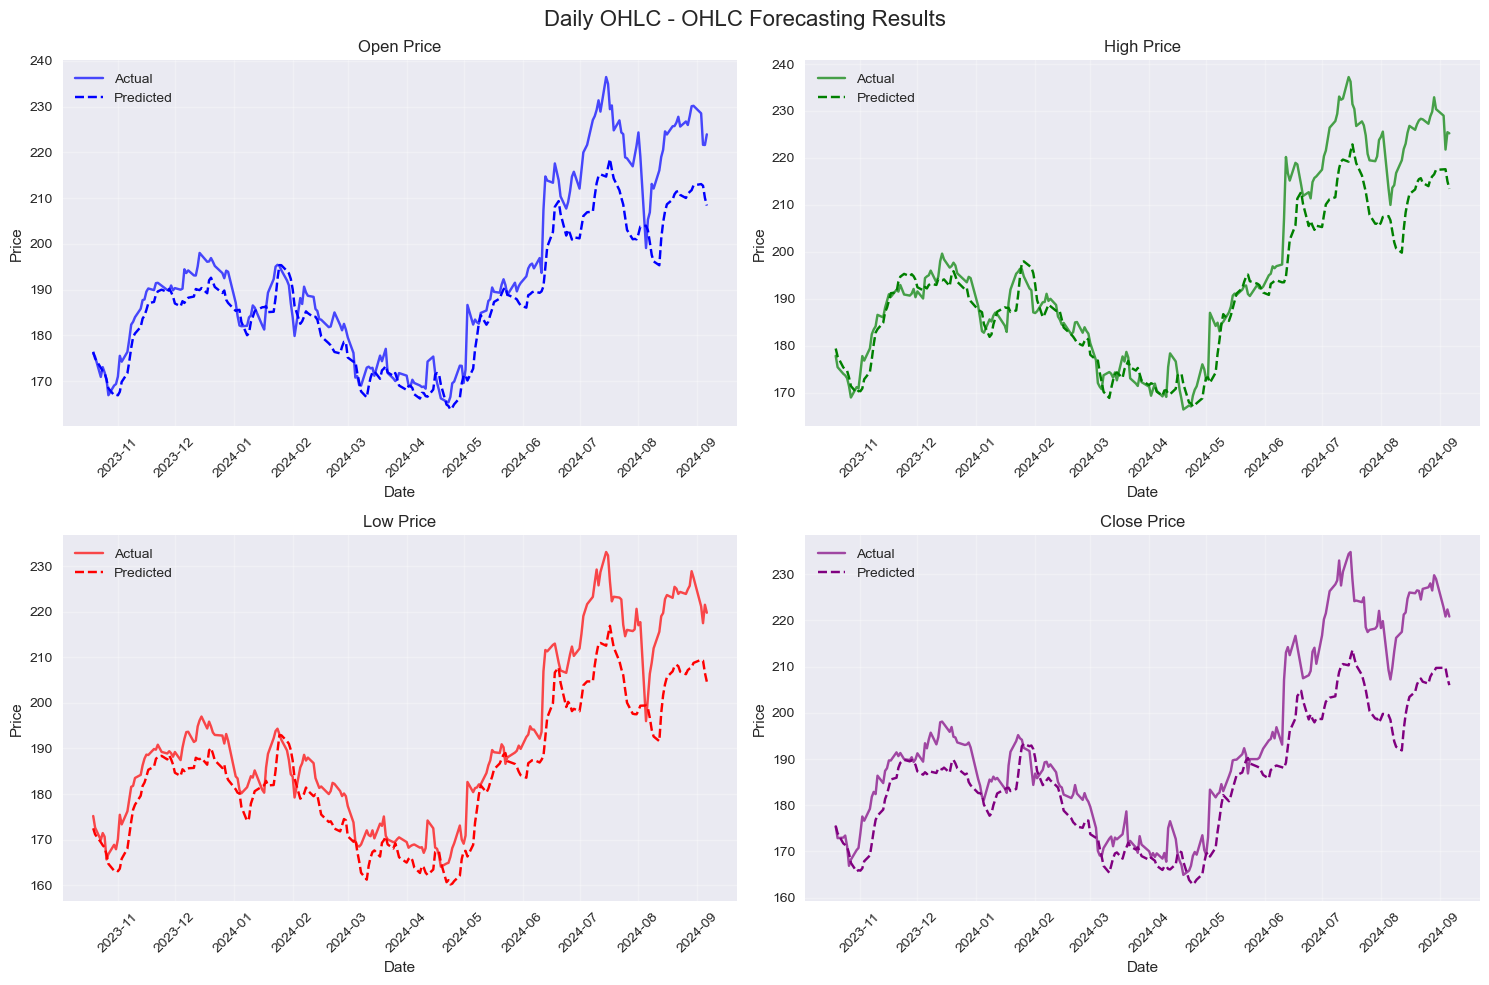


=== NEXT MONTH OHLC FORECAST ===
Next 30 days OHLC forecast:
                  Open        High         Low       Close
Date                                                      
2024-09-07  204.989334  209.734634  201.173660  202.843628
2024-09-08  203.557205  208.112106  199.836472  201.082672
2024-09-09  202.589478  207.509247  198.940689  200.347183
2024-09-10  201.664520  206.425568  197.699188  199.312210
2024-09-11  202.858810  207.650436  198.564224  200.166946
2024-09-12  204.653961  209.007523  199.995987  201.159332
2024-09-13  205.195648  209.226974  200.743271  200.955887
2024-09-14  203.219635  207.325378  199.176758  199.053192
2024-09-15  201.175705  205.224777  197.586517  197.173538
2024-09-16  198.603821  202.966156  195.286697  195.148987
2024-09-17  197.454803  201.867157  194.399033  194.192352
2024-09-18  196.008224  200.435120  193.375565  192.935242
2024-09-19  201.180603  204.866730  198.484787  197.409027
2024-09-20  205.420868  209.072800  202.661911  201.1

In [1]:
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import warnings

# Layers
Input = tf.keras.layers.Input
LSTM = tf.keras.layers.LSTM
Dense = tf.keras.layers.Dense
Dropout = tf.keras.layers.Dropout
Bidirectional = tf.keras.layers.Bidirectional

# Callbacks
EarlyStopping = tf.keras.callbacks.EarlyStopping
ReduceLROnPlateau = tf.keras.callbacks.ReduceLROnPlateau

# Model
Model = tf.keras.models.Model
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

class OHLCForecaster:
    def __init__(self, frequency='daily'):
        """
        Initialize OHLC Forecaster
        frequency: 'daily' or 'monthly'
        """
        self.frequency = frequency
        self.resample_freq = 'D' if frequency == 'daily' else 'M'
        self.scalers = {}
        self.model = None
        self.df = None
        self.ohlc_df = None
        self.window_size = None
        self.feature_cols = None
        self.scaled_df = None  # Store scaled data for forecasting
        
    def load_and_prepare_data(self, data_path, recent_years=10):
        """Load and prepare OHLC data with option to use recent data only"""
        print(f"[] Loading data for {self.frequency} forecasting...")
        
        # Read data
        df = pd.read_csv(data_path)
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)
        df = df.sort_index()
        
        # Use only recent data for better relevance
        if recent_years:
            cutoff_date = df.index.max() - pd.DateOffset(years=recent_years)
            df = df[df.index >= cutoff_date]
            print(f"[] Using data from {cutoff_date.date()} onwards")
        
        # Resample to desired frequency with OHLC
        self.ohlc_df = df.resample(self.resample_freq).agg({
            'Open': 'first',
            'High': 'max',
            'Low': 'min',
            'Close': 'last',
            'Volume': 'sum'
        }).dropna()
        
        print(f"[] {self.frequency.capitalize()} OHLC data shape: {self.ohlc_df.shape}")
        return self.ohlc_df
    
    def add_technical_indicators(self, dataset):
        """Add technical indicators for OHLC forecasting"""
        print("[] Adding technical indicators...")
        
        # For each price type, add basic indicators
        for price_type in ['Open', 'High', 'Low', 'Close']:
            # Moving averages
            dataset[f'{price_type}_ma7'] = dataset[price_type].rolling(window=7).mean()
            dataset[f'{price_type}_ma20'] = dataset[price_type].rolling(window=20).mean()
            
            # Exponential moving averages
            dataset[f'{price_type}_ema12'] = dataset[price_type].ewm(span=12).mean()
            
            # Momentum and returns
            dataset[f'{price_type}_returns'] = dataset[price_type].pct_change()
            dataset[f'{price_type}_momentum'] = dataset[price_type].diff(5)
        
        # Volume indicators
        dataset['Volume_ma20'] = dataset['Volume'].rolling(window=20).mean()
        dataset['Volume_returns'] = dataset['Volume'].pct_change()
        
        # RSI for Close price
        self.calculate_rsi(dataset, 'Close')
        
        # Volatility (Bollinger Bands for Close)
        dataset['Close_20sd'] = dataset['Close'].rolling(window=20).std()
        dataset['Close_upper_band'] = dataset['Close'].rolling(window=20).mean() + (2 * dataset['Close_20sd'])
        dataset['Close_lower_band'] = dataset['Close'].rolling(window=20).mean() - (2 * dataset['Close_20sd'])
        
        return dataset
    
    def calculate_rsi(self, dataset, price_type='Close', period=14):
        """Calculate RSI for specified price type"""
        delta = dataset[price_type].diff()
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)
        
        avg_gain = gain.rolling(window=period).mean()
        avg_loss = loss.rolling(window=period).mean()
        
        rs = avg_gain / avg_loss
        dataset[f'{price_type}_RSI'] = 100 - (100 / (1 + rs))
        
        return dataset
    
    def add_time_features(self, dataset):
        """Add time-based features"""
        dataset['Day_of_week'] = dataset.index.dayofweek
        dataset['Month'] = dataset.index.month
        dataset['Quarter'] = dataset.index.quarter
        dataset['Time_Index'] = np.arange(len(dataset))
        
        return dataset
    
    def scale_training_features(self, dataset):
        """Scale features using training data only (prevents data leakage)"""
        print("[] Scaling training features...")
        
        # Scale each OHLC price separately
        for price_type in ['Open', 'High', 'Low', 'Close']:
            scaler = MinMaxScaler()
            dataset[f'{price_type}_scaled'] = scaler.fit_transform(dataset[[price_type]])
            self.scalers[price_type] = scaler
        
        # Scale volume
        volume_scaler = MinMaxScaler()
        dataset['Volume_scaled'] = volume_scaler.fit_transform(dataset[['Volume']])
        self.scalers['Volume'] = volume_scaler
        
        # Scale technical indicators
        tech_cols = [col for col in dataset.columns if any(x in col for x in 
                    ['ma', 'ema', 'returns', 'momentum', 'RSI', 'sd', 'band'])]
        tech_scaler = MinMaxScaler()
        dataset[tech_cols] = tech_scaler.fit_transform(dataset[tech_cols].fillna(0))
        self.scalers['technical'] = tech_scaler
        
        # Scale time features
        time_cols = ['Day_of_week', 'Month', 'Quarter', 'Time_Index']
        time_scaler = MinMaxScaler()
        dataset[time_cols] = time_scaler.fit_transform(dataset[time_cols])
        self.scalers['time'] = time_scaler
        
        return dataset
    
    def scale_test_features(self, dataset):
        """Scale test data using pre-fitted training scalers"""
        if not self.scalers:
            raise ValueError("Scalers not fitted! Call scale_training_features first.")
        
        # Scale each OHLC price using training scalers
        for price_type in ['Open', 'High', 'Low', 'Close']:
            dataset[f'{price_type}_scaled'] = self.scalers[price_type].transform(dataset[[price_type]])
        
        # Scale volume
        dataset['Volume_scaled'] = self.scalers['Volume'].transform(dataset[['Volume']])
        
        # Scale technical indicators
        tech_cols = [col for col in dataset.columns if any(x in col for x in 
                    ['ma', 'ema', 'returns', 'momentum', 'RSI', 'sd', 'band'])]
        dataset[tech_cols] = self.scalers['technical'].transform(dataset[tech_cols].fillna(0))
        
        # Scale time features
        time_cols = ['Day_of_week', 'Month', 'Quarter', 'Time_Index']
        dataset[time_cols] = self.scalers['time'].transform(dataset[time_cols])
        
        return dataset
    
    def prepare_features(self, dataset):
        """Prepare feature columns list"""
        # Define feature columns (exclude targets and original prices)
        self.feature_cols = [col for col in dataset.columns if col not in [
            'Open_scaled', 'High_scaled', 'Low_scaled', 'Close_scaled',
            'Open', 'High', 'Low', 'Close', 'Volume'
        ] and not col.startswith('target_')]
        
        return self.feature_cols
    
    def create_sequences_properly(self, dataset, window_size=10, target_cols=['Open_scaled', 'High_scaled', 'Low_scaled', 'Close_scaled'], test_size=0.2):
        """Create sequences with proper temporal splitting to prevent data leakage"""
        # First split temporally (no shuffling for time series!)
        split_idx = int(len(dataset) * (1 - test_size))
        train_data = dataset.iloc[:split_idx].copy()
        test_data = dataset.iloc[split_idx:].copy()
        
        # Scale training data
        train_scaled = self.scale_training_features(train_data)
        
        # Scale test data using training scalers
        test_scaled = self.scale_test_features(test_data)
        
        # Store the full scaled dataset for forecasting
        self.scaled_df = pd.concat([train_scaled, test_scaled])
        
        # Prepare feature columns
        self.prepare_features(train_scaled)
        
        # Create sequences
        X_train, y_train = self._create_sequences(train_scaled, window_size, target_cols)
        X_test, y_test = self._create_sequences(test_scaled, window_size, target_cols)
        
        return X_train, y_train, X_test, y_test, train_scaled.index, test_scaled.index
    
    def _create_sequences(self, dataset, window_size, target_cols):
        """Create sequences from prepared data"""
        X, y = [], []
        for i in range(window_size, len(dataset)):
            X.append(dataset[self.feature_cols].iloc[i-window_size:i].values)
            y.append(dataset[target_cols].iloc[i].values)
        
        return np.array(X), np.array(y)
    
    def build_multi_output_model(self, window_size, num_features):
        """Build BiLSTM model with multiple outputs for OHLC"""
        
        inputs = Input(shape=(window_size, num_features))
        
        # Shared BiLSTM layers
        x = Bidirectional(LSTM(64, return_sequences=True))(inputs)
        x = Dropout(0.3)(x)
        x = Bidirectional(LSTM(32))(x)
        x = Dropout(0.2)(x)
        
        # Separate output layers for each OHLC
        open_output = Dense(32, activation='relu')(x)
        open_output = Dropout(0.1)(open_output)
        open_output = Dense(1, name='open_output')(open_output)
        
        high_output = Dense(32, activation='relu')(x)
        high_output = Dropout(0.1)(high_output)
        high_output = Dense(1, name='high_output')(high_output)
        
        low_output = Dense(32, activation='relu')(x)
        low_output = Dropout(0.1)(low_output)
        low_output = Dense(1, name='low_output')(low_output)
        
        close_output = Dense(32, activation='relu')(x)
        close_output = Dropout(0.1)(close_output)
        close_output = Dense(1, name='close_output')(close_output)
        
        model = Model(inputs=inputs, outputs=[open_output, high_output, low_output, close_output])
        
        # Specify metrics for each output
        model.compile(
            optimizer='adam',
            loss={
                'open_output': 'mse',
                'high_output': 'mse',
                'low_output': 'mse',
                'close_output': 'mse'
            },
            loss_weights=[0.25, 0.25, 0.25, 0.25],
            metrics={
                'open_output': ['mae'],
                'high_output': ['mae'],
                'low_output': ['mae'],
                'close_output': ['mae']
            }
        )
        
        return model
    
    def train_model(self, X_train, y_train, X_val, y_val, epochs=100, batch_size=32):
        """Train the multi-output model with proper validation"""
        
        early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
        
        print("[] Training multi-output OHLC model...")
        
        # Prepare validation data for multi-output
        val_data = {
            'open_output': y_val[:, 0],
            'high_output': y_val[:, 1],
            'low_output': y_val[:, 2],
            'close_output': y_val[:, 3]
        }
        
        history = self.model.fit(
            X_train, 
            {
                'open_output': y_train[:, 0],
                'high_output': y_train[:, 1],
                'low_output': y_train[:, 2],
                'close_output': y_train[:, 3]
            },
            validation_data=(X_val, val_data),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stop, reduce_lr],
            verbose=1
        )
        
        return history
    
    def prepare_full_dataset(self, data_path, recent_years=10):
        """Complete data preparation pipeline without scaling"""
        # Load and prepare data
        df = self.load_and_prepare_data(data_path, recent_years)
        
        # Add features
        df = self.add_technical_indicators(df)
        df = self.add_time_features(df)
        
        # Fill NaN values
        df = df.fillna(method='ffill').fillna(method='bfill')
        
        self.df = df
        return df
    
    def train_full_model(self, data_path, window_size=20, test_size=0.2, recent_years=10):
        """Complete training pipeline with proper data handling for OHLC"""
        self.window_size = window_size
        
        # Prepare data (without scaling yet)
        df = self.prepare_full_dataset(data_path, recent_years)
        
        # Target columns for OHLC
        target_cols = ['Open_scaled', 'High_scaled', 'Low_scaled', 'Close_scaled']
        
        # Create sequences with proper scaling (prevents data leakage)
        X_train, y_train, X_test, y_test, train_idx, test_idx = self.create_sequences_properly(
            df, window_size=window_size, target_cols=target_cols, test_size=test_size
        )
        
        # Build model
        num_features = X_train.shape[2]
        self.model = self.build_multi_output_model(window_size, num_features)
        
        # Split training data further for validation
        val_size = int(len(X_train) * 0.2)
        X_train_final, X_val = X_train[:-val_size], X_train[-val_size:]
        y_train_final, y_val = y_train[:-val_size], y_train[-val_size:]
        
        # Train model
        history = self.train_model(X_train_final, y_train_final, X_val, y_val)
        
        return history, X_train, y_train, X_test, y_test, train_idx, test_idx
    
    def predict(self, X):
        """Make predictions for all OHLC outputs"""
        if self.model is None:
            raise ValueError("Model not trained yet!")
        
        predictions = self.model.predict(X)
        return predictions
    
    def inverse_transform_predictions(self, predictions, price_type):
        """Convert scaled predictions back to original scale for specific price type"""
        if price_type not in self.scalers:
            raise ValueError(f"Scaler for {price_type} not found!")
        
        unscaled = self.scalers[price_type].inverse_transform(predictions.reshape(-1, 1))
        return unscaled.flatten()
    
    def evaluate_ohlc_model(self, X_test, y_test):
        """Evaluate model performance for all OHLC components"""
        predictions = self.predict(X_test)
        
        results = {}
        price_types = ['Open', 'High', 'Low', 'Close']
        
        for i, price_type in enumerate(price_types):
            # Inverse transform predictions and actual values
            unscaled_preds = self.inverse_transform_predictions(predictions[i], price_type)
            unscaled_actuals = self.inverse_transform_predictions(y_test[:, i], price_type)
            
            # Calculate metrics
            metrics = {
                'MAE': mean_absolute_error(unscaled_actuals, unscaled_preds),
                'RMSE': np.sqrt(mean_squared_error(unscaled_actuals, unscaled_preds)),
                'MAPE': mean_absolute_percentage_error(unscaled_actuals, unscaled_preds) * 100,
                'R2': r2_score(unscaled_actuals, unscaled_preds)
            }
            
            results[price_type] = {
                'metrics': metrics,
                'actuals': unscaled_actuals,
                'predictions': unscaled_preds
            }
        
        return results
    
    def forecast_future_ohlc(self, steps=5):
        """Forecast future OHLC values using the scaled data"""
        if self.scaled_df is None or self.window_size is None or self.feature_cols is None:
            raise ValueError("Data not prepared properly for forecasting!")
        
        # Get the last window from the scaled data (which has all the scaled features)
        current_window = self.scaled_df[self.feature_cols].iloc[-self.window_size:].values
        current_window = current_window.reshape(1, self.window_size, -1)
        
        future_predictions_scaled = {'Open': [], 'High': [], 'Low': [], 'Close': []}
        
        for _ in range(steps):
            # Predict next step
            preds = self.model.predict(current_window, verbose=0)
            
            # Store scaled predictions
            for i, price_type in enumerate(['Open', 'High', 'Low', 'Close']):
                future_predictions_scaled[price_type].append(preds[i][0][0])
            
            # For a proper implementation, you'd update the feature window here
            # This is simplified for demonstration - we just shift the window
            current_window = np.roll(current_window, -1, axis=1)
        
        # Convert to unscaled values
        unscaled_future = {}
        for price_type in ['Open', 'High', 'Low', 'Close']:
            unscaled_future[price_type] = self.inverse_transform_predictions(
                np.array(future_predictions_scaled[price_type]), price_type
            )
        
        # Create future dates
        last_date = self.scaled_df.index[-1]
        if self.frequency == 'daily':
            future_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=steps, freq='D')
        else:
            future_dates = pd.date_range(last_date + pd.DateOffset(months=1), periods=steps, freq='M')
        
        # Create result DataFrame
        result_df = pd.DataFrame({
            'Date': future_dates,
            'Open': unscaled_future['Open'],
            'High': unscaled_future['High'],
            'Low': unscaled_future['Low'],
            'Close': unscaled_future['Close']
        })
        result_df.set_index('Date', inplace=True)
        
        return result_df

    def plot_ohlc_results(self, results, dates, title_suffix=""):
        """Plot actual vs predicted values for all OHLC components"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle(f'{self.frequency.capitalize()} {title_suffix} - OHLC Forecasting Results', fontsize=16)
        
        price_types = ['Open', 'High', 'Low', 'Close']
        colors = ['blue', 'green', 'red', 'purple']
        
        for i, (price_type, color) in enumerate(zip(price_types, colors)):
            ax = axes[i//2, i%2]
            actuals = results[price_type]['actuals']
            preds = results[price_type]['predictions']
            
            ax.plot(dates, actuals, label='Actual', color=color, alpha=0.7)
            ax.plot(dates, preds, label='Predicted', color=color, linestyle='--')
            
            ax.set_title(f'{price_type} Price')
            ax.set_xlabel('Date')
            ax.set_ylabel('Price')
            ax.legend()
            ax.grid(True, alpha=0.3)
            ax.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
        
    def print_detailed_metrics(self, results):
        """Print detailed metrics for all OHLC components"""
        print("\n=== DETAILED MODEL STATISTICS ===")
        for price_type in ['Open', 'High', 'Low', 'Close']:
            metrics = results[price_type]['metrics']
            print(f"\n{price_type} Price Statistics:")
            print(f"  RMSE: ${metrics['RMSE']:.2f}")
            print(f"  MAE: ${metrics['MAE']:.2f}")
            print(f"  MAPE: {metrics['MAPE']:.2f}%")
            print(f"  R²: {metrics['R2']:.4f}")

# Example usage
def main():
    # Initialize forecaster
    daily_forecaster = OHLCForecaster(frequency='daily')
    
    # Train daily model with OHLC outputs
    print("=== DAILY OHLC FORECASTING ===")
    try:
        history, X_train, y_train, X_test, y_test, train_idx, test_idx = daily_forecaster.train_full_model(
            'datasets/aapl_us_d.csv', 
            window_size=30,
            test_size=0.2,
            recent_years=5
        )
    except Exception as e:
        print(f"Error training daily model: {e}")
        return
    
    # Evaluate OHLC model
    print("\n=== OHLC EVALUATION ===")
    results = daily_forecaster.evaluate_ohlc_model(X_test, y_test)
    
    # Print detailed metrics
    daily_forecaster.print_detailed_metrics(results)
    
    # Plot results
    test_dates = daily_forecaster.scaled_df.index[-len(results['Open']['actuals']):]
    daily_forecaster.plot_ohlc_results(results, test_dates, "OHLC")
    
    # Future forecasting for next month (approx 30 days)
    print("\n=== NEXT MONTH OHLC FORECAST ===")
    try:
        days_in_month = 30
        future_ohlc = daily_forecaster.forecast_future_ohlc(steps=days_in_month)
        
        print(f"Next {days_in_month} days OHLC forecast:")
        print(future_ohlc)
        
        # Print formatted forecast
        print("\nFormatted Forecast:")
        for date, row in future_ohlc.iterrows():
            print(f"{date.strftime('%Y-%m-%d')}: O=${row['Open']:.2f}, H=${row['High']:.2f}, L=${row['Low']:.2f}, C=${row['Close']:.2f}")
            
    except Exception as e:
        print(f"Error in forecasting: {e}")
        import traceback
        traceback.print_exc()
    
    # Save model
    try:
        daily_forecaster.model.save(f'daily_ohlc_forecaster_{tf.__version__}.keras')
        print("\n[] Model saved successfully!")
    except Exception as e:
        print(f"Error saving model: {e}")

if __name__ == "__main__":
    main()